In [1]:
import numpy as np

from torch.utils.data import Dataset

class CharSequenceDataset(Dataset):
    def __init__(self, path, batch_size, seq_length, one_hot_encoding=False):
        self.one_hot_encoding = one_hot_encoding
        
        self.batch_size = batch_size
        self.seq_length = seq_length

        with open(path) as f: text = f.read()

        # leave only characters that can be represented as matrix
        text = text[:len(text) // self.batch_size * self.batch_size]
        
        self.chars = tuple(set(text))
        self.n_tokens = len(self.chars)
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {c: i for i, c in self.int2char.items()}

        encoded_text = np.array([self.char2int[ch] for ch in text])
        encoded_text_matrix = encoded_text.reshape(self.batch_size, -1)
        
        self.n_batches = (encoded_text_matrix.shape[1] - 1) // self.seq_length
        X = encoded_text_matrix[:,  :self.n_batches * self.seq_length    ]
        Y = encoded_text_matrix[:, 1:self.n_batches * self.seq_length + 1]
        
        self.xs = self.matrix_to_seq_list(X)
        self.ys = self.matrix_to_seq_list(Y)

    def matrix_to_seq_list(self, M):
        return M.reshape(self.batch_size, -1, self.seq_length).transpose(1, 0, 2).reshape(-1, self.seq_length)
    
    def seq_to_one_hot_code(self, x):
        code = np.zeros((len(x), self.n_tokens), dtype=np.float32)
        code[np.arange(len(x)), x] = 1.
        return code
        
    def __getitem__(self, index):
        x, y = self.xs[index], self.ys[index]
        
        if self.one_hot_encoding:
            return self.seq_to_one_hot_code(x), y
        else:
            return x, y
        
    def __len__(self):
        return self.n_batches * self.batch_size

In [2]:
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, SequentialSampler

batch_size = 128
seq_length = 150

dataset = CharSequenceDataset("data/anna.txt",
                              batch_size=batch_size,
                              seq_length=seq_length,
                              one_hot_encoding=True)

train_idx, test_idx = train_test_split(np.arange(len(dataset)), shuffle=False)

train_sampler = SequentialSampler(train_idx)
test_sampler  = SequentialSampler(test_idx)

train_loader = DataLoader(dataset, batch_size=batch_size)
test_loader  = DataLoader(dataset, batch_size=batch_size)

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
from torch import nn

import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self, n_tokens):
        super().__init__()
        
        self.input_size  = n_tokens
        self.output_size = n_tokens
        self.hidden_size = 512
        self.n_layers    = 2
        
        self.lstm = nn.LSTM(self.input_size,
                            self.hidden_size,
                            self.n_layers,
                            dropout=0.5,
                            batch_first=True)
        
        self.fc1 = nn.Linear(self.hidden_size, 64)
        self.fc2 = nn.Linear(64, self.output_size)
        
        self.dropout = nn.Dropout()
        
    def init_hidden(self, batch_size, device="cpu"):
        self.hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device),
                       torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))
        
        return self.hidden
    
    def reset_hidden(self):
        self.hidden = (self.hidden[0].data,
                       self.hidden[1].data)
        
        return self.hidden
        
    def forward(self, x):
        out, self.hidden = self.lstm(x, self.hidden)
        x = out.contiguous().view(-1, self.hidden_size)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [5]:
from torch import optim
from tqdm import tqdm

model = Network(dataset.n_tokens).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

step = 1
n_epochs = 10
log_every_n_steps = 50

cum_train_loss = 0.

train_losses, test_losses = [], []

for epoch in tqdm(range(n_epochs)):
    model.init_hidden(batch_size, device)
    
    for x, y in train_loader:
        x, y = x.to(device), y.reshape(-1).to(device)
        
        logits = model.forward(x)
        loss = criterion(logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        
        model.reset_hidden()
        cum_train_loss += loss.item()
        
        if step % log_every_n_steps == 0:
            cum_test_loss = 0.
            
            model.eval()
            model.init_hidden(batch_size, device)
            
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.reshape(-1).to(device)
                    
                    logits = model.forward(x)
                    loss = criterion(logits, y)
                    
                    model.reset_hidden()
                    cum_test_loss += loss.item()
            
            model.train()

            train_loss = cum_train_loss / log_every_n_steps
            test_loss  = cum_test_loss  / len(test_loader)
    
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            cum_train_loss = 0.
        
        step += 1

100%|██████████| 10/10 [08:56<00:00, 53.75s/it]


In [6]:
%config InlineBackend.figure_format = "retina"

%matplotlib inline

import matplotlib.pyplot as plt

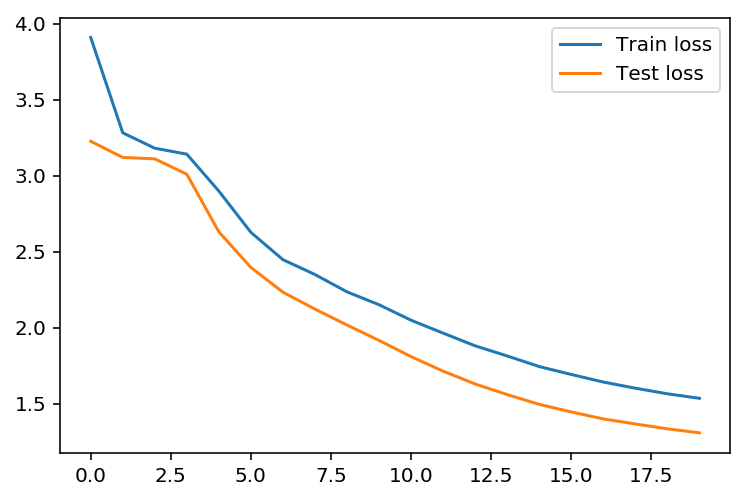

In [7]:
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

In [9]:
prime = "Once upon a time "

with torch.no_grad():
    model.eval()
    model.init_hidden(1, device)

    def char_to_tensor(ch):
        token = dataset.char2int[ch]
        one_hot_code = dataset.seq_to_one_hot_code([token])
        return torch.from_numpy(one_hot_code[np.newaxis, :]).to(device)

    def logits_to_char(logits):
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(3, dim=1)
        
        top_p     = top_p.    squeeze().cpu().numpy()
        top_class = top_class.squeeze().cpu().numpy()
        
        ix = np.random.choice(top_class, p=top_p / top_p.sum())
        
        return dataset.int2char[ix]

    for ch in prime[:-1]: model.forward(char_to_tensor(ch))

    for _ in range(1000):
        tensor = char_to_tensor(prime[-1])
        logits = model.forward(tensor)
        prime += logits_to_char(logits)

print(prime)

Once upon a time he had seen her."

"It this shoulder, she and any sorts, standed, as he said to the conversation of her, and holding the steps. And there already told the country, and all the
state of her hands."

And his hand, and so his son and the countrain, and
he
had not said something thoughs the property and
what was to say the state of his
hand of that too that her heart.

"There are you the course.
And alreing that. I'm that I have the strength and the strength. And that a signitanic she said, shalt to, and the propacior, and that they are talking, so talked," said her, the children had not chest the contristion and had been thought of the countrae to the countess as, and her and that that
seemed of her, and that he had said. "Well, he shall be a man of his show and won't be talked," he said.

"It's an instant, and the same side of that same, and had all them.

And anything to the
people,
and to the same the state of the cordition to tack of the position, and the proness of a